# GAN для генерации рукописных цифр (MNIST) с использованием PyTorch

Воспользовался самописным `GAN` для `MNIST`

Была сделана модификация `Conditional GAN`

# Imports

In [18]:
import os
import shutil

In [19]:
from PIL import Image, ImageDraw, ImageFont

In [20]:
from IPython import display
import matplotlib.pyplot as plt

In [21]:
import tensorflow as tf

In [22]:
from keras import (
    layers,
    optimizers,
    losses,
    datasets,
    Model,
    metrics,
    callbacks,
)
from keras.models import load_model
from keras.src.utils import file_utils
from keras.utils import to_categorical

# Params

In [23]:
BUFFER_SIZE = 100000
EPOCHS = 100
BATCH_SIZE = 2**5
NOISE_DIM = int(10e1)
NUM_CLASSES = 10

In [24]:
folders = {"img": "gan_images", "check": "gan_checkpoints", "model": "gan_models"}

# Data preparation

In [25]:
(train_images, train_labels), (_, _) = datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
train_labels = to_categorical(train_labels, NUM_CLASSES)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator

In [26]:
class Generator(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Объединенный вход: шум + метка
        self.fc = layers.Dense(7 * 7 * 256, use_bias=False)
        self.bn0 = layers.BatchNormalization()

        self.conv1 = layers.Conv2DTranspose(
            128, (5, 5), strides=(1, 1), padding="same", use_bias=False
        )
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv2DTranspose(
            64, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
        self.bn2 = layers.BatchNormalization()

        self.conv3 = layers.Conv2DTranspose(
            1, (5, 5), strides=(2, 2), padding="same", activation="sigmoid"
        )

        self.relu = layers.ReLU()

    def call(self, inputs, training=False):
        noise, label = inputs
        # Объединение шума и метки
        x = tf.concat([noise, label], axis=1)
        x = self.fc(x)
        x = self.bn0(x, training=training)
        x = self.relu(x)
        x = tf.reshape(x, (-1, 7, 7, 256))

        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)

        return self.conv3(x)


    # def build(self, img_shape):
    #     # Метод для явной инициализации и проверки архитектуры
    #     x = Input(shape=img_shape)
    #     return Model(inputs=[x], outputs=self.call(x))

In [27]:
generator = Generator()

In [28]:
def generate_digit(digit_class, generator, num_examples=1):
    noise = tf.random.normal([num_examples, NOISE_DIM])
    labels = tf.one_hot([digit_class] * num_examples, depth=NUM_CLASSES)
    generated = generator([noise, labels], training=False)

    plt.figure(figsize=(num_examples * 3, 3))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(generated[i, :, :, 0] * 255.0, cmap="gray")
        plt.title(f"Digit: {digit_class}")
        plt.axis("off")
    plt.show()

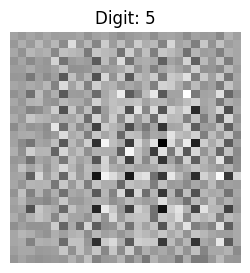

In [29]:
generate_digit(5, generator, num_examples=1)

# Discriminator

In [30]:
class Discriminator(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Встроенный слой для меток
        self.label_embedding = layers.Dense(28 * 28)

        self.conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same")
        self.conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")

        self.flatten = layers.Flatten()
        self.fc = layers.Dense(1)

        self.leaky_relu = layers.LeakyReLU(0.2)
        self.dropout = layers.Dropout(0.3)

    def call(self, inputs, training=False):
        image, label = inputs

        # Преобразование метки в изображение
        label_img = self.label_embedding(label)
        label_img = tf.reshape(label_img, (-1, 28, 28, 1))

        # Объединение с изображением
        x = tf.concat([image, label_img], axis=-1)

        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x, training=training)

        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x, training=training)

        x = self.flatten(x)
        return self.fc(x)


    # def build(self, img_shape):
    #     # Метод для явной инициализации и проверки архитектуры
    #     x = Input(shape=img_shape)
    #     return Model(inputs=[x], outputs=self.call(x))

In [31]:
discriminator = Discriminator()

In [32]:
noise = tf.random.normal([1, NOISE_DIM])
labels = tf.one_hot([5] * 1, depth=NUM_CLASSES)
generated = generator([noise, labels], training=False)

discriminator([generated, labels])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04766426]], dtype=float32)>

# GAN

In [33]:
class ConditionalGAN(Model):
    def __init__(self, generator: Generator, discriminator: Discriminator, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.noise_dim = NOISE_DIM

        # Фиксированные данные для визуализации
        self.fixed_noise = tf.random.normal([10, NOISE_DIM])
        self.fixed_labels = tf.one_hot(tf.range(0, 10), depth=NUM_CLASSES)

        # Инициализация метрик в конструкторе
        self.gen_loss_tracker = metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = metrics.Mean(name="discriminator_loss")

    def compile(
        self,
        g_optimizer: optimizers.Optimizer,
        d_optimizer: optimizers.Optimizer,
        loss_fn,
    ):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "generator": tf.keras.utils.serialize_keras_object(self.generator),
                "discriminator": tf.keras.utils.serialize_keras_object(
                    self.discriminator
                ),
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        generator = tf.keras.utils.deserialize_keras_object(config["generator"])
        discriminator = tf.keras.utils.deserialize_keras_object(config["discriminator"])
        return cls(generator, discriminator)

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def train_step(self, data):
        real_images, real_labels = data

        # Генерация случайных меток для фейковых изображений
        batch_size = tf.shape(real_images)[0]
        random_labels = tf.one_hot(
            tf.random.uniform([batch_size], maxval=NUM_CLASSES, dtype=tf.int32),
            NUM_CLASSES,
        )

        # Генерация шума
        noise = tf.random.normal([batch_size, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Генерация изображений
            fake_images = self.generator([noise, random_labels], training=True)

            # Оценка дискриминатора
            real_output = self.discriminator([real_images, real_labels], training=True)
            fake_output = self.discriminator(
                [fake_images, random_labels], training=True
            )

            # Вычисление потерь
            disc_loss = self.loss_fn.discriminator_loss(real_output, fake_output)
            gen_loss = self.loss_fn.generator_loss(fake_output)

        # Обновление генератора
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradients, self.generator.trainable_variables)
        )

        # Обновление дискриминатора
        disc_gradients = disc_tape.gradient(
            disc_loss, self.discriminator.trainable_variables
        )
        self.d_optimizer.apply_gradients(
            zip(disc_gradients, self.discriminator.trainable_variables)
        )

        # Обновление метрик
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


# Функции потерь
class GANLoss:
    def __init__(self):
        self.binary_cross_entropy = losses.BinaryCrossentropy(from_logits=True)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.binary_cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(self, fake_output):
        return self.binary_cross_entropy(tf.ones_like(fake_output), fake_output)


# Коллбэк для генерации изображений
class ImageCallback(callbacks.Callback):
    def __init__(self, filepath: str, save_freq: str | int = "epoch"):
        super().__init__()
        self.filepath: str = file_utils.path_to_string(filepath)
        self.save_freq: str | int = save_freq
        self._epoches_seen_since_last_saving = 0

        if self.save_freq != "epoch" and not isinstance(self.save_freq, int):
            raise ValueError(
                f"Unrecognized save_freq: {self.save_freq}. "
                "Expected save_freq are 'epoch' or integer values"
            )

        if not self.filepath.endswith((".png", ".jpg")):
            raise ValueError(
                "Wrong image filepath extension!"
                "Received: "
                f"filepath={self.filepath}"
            )

    def on_epoch_end(self, epoch: int, logs=None):
        noise = self.model.fixed_noise
        labels = self.model.fixed_labels
        images = self.model.generator([noise, labels], training=False)

        print(f"Epoch {epoch}/{EPOCHS}")

        display.clear_output(wait=True)

        plt.figure(figsize=(10, 4))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i, :, :, 0] * 255.0, cmap="gray")
            plt.title(f"Digit: {i}")
            plt.axis("off")

        if self._should_save_on_epoch():
            plt.savefig(self._get_file_path(epoch))

        plt.show()

    def _should_save_on_epoch(self):
        if self.save_freq == "epoch":
            return True

        self._epoches_seen_since_last_saving += 1

        if self._epoches_seen_since_last_saving >= self.save_freq:
            self._epoches_seen_since_last_saving = 0
            return True
        return False

    def _get_file_path(self, epoch):
        return self.filepath.format(epoch=epoch + 1)

# Train

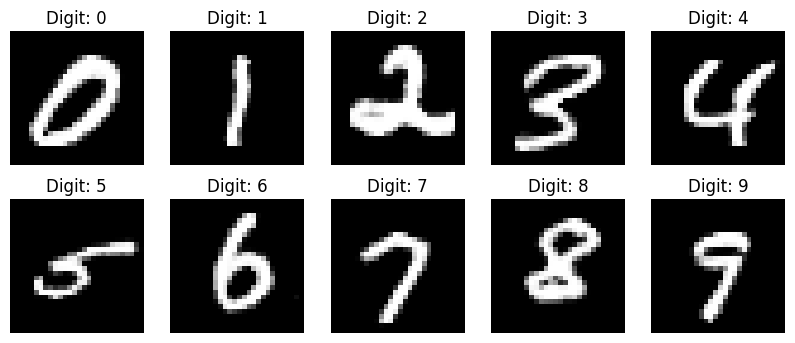

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - d_loss: 1.3727 - g_loss: 0.7174


In [34]:
# Инициализация и обучение
cgan = ConditionalGAN(generator, discriminator)
cgan.compile(
    g_optimizer=optimizers.Adam(1e-4, beta_1=0.5),
    d_optimizer=optimizers.Adam(1e-4, beta_1=0.5),
    loss_fn=GANLoss(),
)

cgan.build((None, 28, 28, 1))



for folder in folders.values():
    if os.path.exists(folder):
        shutil.rmtree(folder)

# Создаем директории для сохранения
os.makedirs(folders["img"])
os.makedirs(folders["check"])
os.makedirs(folders["model"])

history = cgan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[
        ImageCallback(os.path.join(folders["img"], "{epoch}.png"), save_freq=1),
        callbacks.ModelCheckpoint(
            os.path.join(folders["check"], "ckpt_{epoch}.keras"),
            # save_weights_only=True,
            save_freq=5 * len(train_dataset),
        ),
    ],
)

# Save

In [35]:
def save_model(model, model_name):
    model.save(os.path.join(folders["model"], f"{model_name}.keras"))

In [36]:
save_model(cgan, "cgan")
save_model(generator, "generator")
save_model(discriminator, "discriminator")

# Test

## Load (Beta)

По-хорошему надо ещё использовать `@register_keras_serializable()`, чтобы полноценно загружать cgan, но я не до конца разобрался в этом вопросе.

На момент прогонки код будет закомментирован, но он вполне себе работоспособен.

In [37]:
# def get_model(model_name, obj_type = None, should_train=False):
#     """Загружает пользовательскую модель из файла"""
#     model_path = os.path.join(folders["model"], f"{model_name}.keras")
#     return load_model(
#         model_path,
#         custom_objects=obj_type,
#         compile=should_train,
#     )

In [38]:
# custom_objects={
#         "Generator": Generator,
#         "Discriminator": Discriminator,
#         "ConditionalGAN": ConditionalGAN,
#         "GANLoss": GANLoss
#     }

# # cgan = get_model("cgan", custom_objects)
# generator = get_model("generator", custom_objects)
# discriminator = get_model("discriminator", custom_objects)

In [39]:
# cgan = ConditionalGAN(generator, discriminator)

## Test

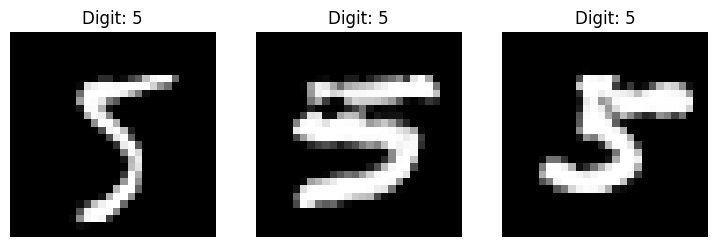

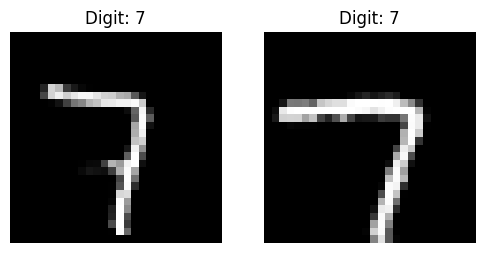

In [40]:
generate_digit(5, cgan.generator, num_examples=3)  # Сгенерировать 3 пятерки
generate_digit(7, cgan.generator, num_examples=2)  # Сгенерировать 2 семерки

# GIF

In [41]:
frames = []

# Настройки шрифта для подписи
font_size = 20
try:
    # Пробуем загрузить стандартный шрифт (работает в большинстве систем)
    font = ImageFont.truetype("arial.ttf", font_size)
except:
    try:
        # Альтернативный шрифт для Linux-систем
        font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    except:
        # Резервный вариант - используем базовый шрифт
        font = ImageFont.load_default()

for frame_number in range(1, EPOCHS + 1):
    img_path = os.path.join(folders["img"], f"{frame_number}.png")
    frame = Image.open(img_path)

    if frame.mode != "RGB":
        frame = frame.convert("RGB")

    draw = ImageDraw.Draw(frame)

    epoch_text = f"Epoch: {frame_number}"

    text_width = draw.textlength(epoch_text, font=font)
    text_height = font_size  # Примерная высота

    position = (
        (frame.width - text_width) // 2,  # X: центр
        frame.height - text_height - 10,  # Y: отступ 10px от низа
    )

    draw.text(xy=position, text=epoch_text, fill="black", font=font)

    frames.append(frame)

gif_path = "gan_gif.gif"

if os.path.exists(gif_path):
    os.remove(gif_path)

frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    optimize=True,
    duration=100,
    loop=0,
)

# Домашка (дедлайн 20.06)

отправлять в тг: @anna_getun, если будут вопросы, также можно писать

Задача: модицифировать код с использованием рассмотренных в лекции методов (DCGAN, Conditional GAN, StyleGAN).
- Достаточно использование одной модели на выбор
- Можно использовать другие датасеты на выбор
- Увеличить параметры (Epoch, batch) для улучшения качества картинок (**обязательно**)

**Пример**

- DCGAN - поиграться со слоями в генераторе

- Сonditional GAN - создать функцию для генерации изображений заданного(-ых) класса(-ов)

- StyleGAN  - добавление шума на всех слоях, модификация генератора и дискриминатора


*не обязательно использовать данный код, можно создать свою собственную модель GAN и модифицировать её

